# Evaluate the existing topics
Review misspelled words
Calculate Coherance Score

In [7]:
import sys
import os

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path+"/scripts")
    sys.path.append(module_path+"/classes")

review_corpus_path = "../data/tech_review_sent_corpus.pkl"
vocab_path = "../data/glove-tech-revew-vocab.txt"
emb_filename = '../models/w2v_embedding'
aspect_file_path = "../results/aspect.json"
aspect_model_path = "../results/model_param"
vocab_path = "../data/vocab-text-review.txt"

# Create coherance score

In [ ]:
import pandas as pd
import pickle

review_corpus_path = "../data/tech_review_sent_corpus.pkl"

with open(review_corpus_path,"rb") as f:
    tech_review_corpus = pickle.load(f)

print(len(tech_review_corpus))

148431


In [17]:
import json
from tqdm import tqdm
from multiprocessing import Pool

with open("../data/stop_words.json", "r") as f:
  stop_words = json.load(f)

def removeStopWords(review):
  tokens = review.split(" ")
  return " ".join([ word for word in tokens if word not in stop_words ])

reviews = pd.DataFrame(tech_review_corpus).review.tolist()

with Pool() as p:
  reviews = list(tqdm(p.imap(removeStopWords, reviews), total=len(reviews)))

100%|██████████| 148431/148431 [00:08<00:00, 17245.43it/s]


In [ ]:
import ABAE.reader as dataset

vocab, train_x, overall_maxlen = dataset.get_data(reviews, vocab_path, vocab_size=0, maxlen=112)

vocab_inv = {}
for w, ind in vocab.items():
    vocab_inv[ind] = w
    
processed_docs = []
for review in train_x:
    processed_docs.append([vocab_inv[i] for i in review ])
    
print(len(train_x))

In [36]:
[ doc for doc in processed_docs if "place" in doc]

[['place',
  'pretty',
  'bore',
  'time',
  'interesting',
  'facility',
  'uranium',
  'enrichment',
  'almost',
  'half',
  'century'],
 ['reasonable', 'pleasant', 'place', 'spend', '<num>', 'hr', 'per', 'work'],
 ['challenge',
  'place',
  'work',
  'manager',
  'five',
  '<num>',
  'user',
  'sole',
  'support',
  'entire',
  'infrastructure'],
 ['definitely', 'place', 'get', 'get', 'reward', 'effort', 'put'],
 ['place', 'customer', 'concern', 'complete', 'satisfactory'],
 ['really',
  'great',
  'place',
  'work',
  'unfortunately',
  'contribute',
  'difficulty',
  'find',
  'advancement'],
 ['great', 'place', 'work'],
 ['place', 'lot', 'scope', 'learn', 'technology'],
 ['wish',
  'never',
  'work',
  'home',
  'depot',
  'bad',
  'place',
  'work',
  '<num>',
  'year',
  'experience',
  'software'],
 ['different', 'race', 'color', 'majority', 'home', 'depot', 'place', 'work'],
 ['great',
  'place',
  'work',
  'management',
  'drink',
  'kool-aid',
  'become',
  'sweat',
  'sho

In [19]:
from datetime import datetime
from gensim.corpora.dictionary import Dictionary

dictionary = Dictionary(processed_docs)
dictionary.add_documents([["<num>","<unk>"]])

corpus = [dictionary.doc2bow(text) for text in processed_docs]

In [30]:
from datetime import datetime
from gensim.models import CoherenceModel
import numpy as np

def calc_coherance(topics):
    u_mass = []
    flags = []
    for n, topic in enumerate(topics):
        cm = CoherenceModel(topics=[topic], corpus=corpus, dictionary=dictionary, coherence='u_mass')
        u_mass.append(cm.get_coherence())
        return np.mean(u_mass)

In [31]:
# https://github.com/derekgreene/topic-model-tutorial/blob/master/3%20-%20Parameter%20Selection%20for%20NMF.ipynb
import gensim
from itertools import combinations
from scipy.spatial.distance import cosine

w2v_model = gensim.models.Word2Vec.load(emb_filename)

def getVector(w2v_model, word):
    try:
        v = w2v_model.wv[word]
    except:
        v = np.repeat(.00000001, w2v_model.vector_size)
    return v

def calculate_coherence(term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( 1 - cosine(getVector(w2v_model, pair[0]), getVector(w2v_model,pair[1])) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)



In [43]:
import json
import os
from multiprocessing import Pool

files = [x for x in os.walk("../results/ABAE")]

models = []
labels = []
topics = []
for t in files[0][2]:
    if (t[:6] == "abae-k") & (t[-4:] == 'json') :
        with open(os.path.join("../results/ABAE",t)) as f:
            aspects = json.load(f)
    
        models.append(t[:-5].split("-"))
        labels.append([ aspect for aspect, words in aspects.items()])
        topics.append([ words for aspect, words in aspects.items() ])
        


with Pool() as p:
    u_mass = list(tqdm(p.imap(calc_coherance, topics),total=len(topics)))
    w2v = list(tqdm(p.imap(calculate_coherence,topics),total=len(topics)))

100%|██████████| 258/258 [02:47<00:00,  1.54it/s]


In [46]:
result = []
for i, m in enumerate(models):
    result.append({
        "k":m[2],
        "ortho":m[4],
        "neg_sent":m[6],
        "umass":u_mass[i],
        "w2v":w2v[i]
    })
    
import pandas as pd
scores_df = pd.DataFrame(result)
print(scores_df.shape)
scores_df.sort_values(by=['umass', 'w2v'], ascending=False).head(20)

(258, 5)


,k,ortho,neg_sent,umass,w2v
219,7,0.75,40,-6.485263,0.244091
88,7,0.01,40,-7.271799,0.265428
56,7,0.5,20,-7.956200,0.226380
248,8,1,50,-8.165523,0.221447
235,5,0.5,50,-8.213506,0.247562
11,5,0.01,30,-8.319049,0.252762
102,8,0.5,10,-8.341435,0.234637
170,7,0.75,30,-8.745610,0.218823
78,8,0.75,10,-8.824033,0.233510
120,8,0.75,50,-9.225727,0.219989


In [45]:
scores_df.to_csv("../data/abae_umass.csv")

## Get List of Words by Topic
Topic Modeling based on K = 10 and Orth = .5.  This gives us best score but most complex words (w2v)

To get topic labels, run `EvaluateABAE.py`, you need to update file with appropiate model

In [47]:
indices = [review["index"] for review in tech_review_corpus]

with open("../results/ABAE/abae-k-7-orth-0.75-neg-40-labels.txt") as f:
    labels = f.readlines()

labels = [ int(label.replace("\n","")) for label in labels ]
    
topics = set(labels)

aspects = { topic:[] for topic in topics }

for label, review in zip(labels, reviews):
    aspects[label].append(review)

In [48]:
x = 0
for aspect, corpus in aspects.items():
    print("Aspect {0} - {1} sentences".format(aspect, len(corpus)))
    x = x + len(corpus)
             
print(x)

Aspect 0 - 22711 sentences
Aspect 1 - 13759 sentences
Aspect 2 - 11919 sentences
Aspect 3 - 18635 sentences
Aspect 4 - 13278 sentences
Aspect 5 - 24668 sentences
Aspect 6 - 43461 sentences
148431


Create a vocab for each topic

In [49]:
from collections import Counter
from nltk import bigrams

aspects_top_vocab = {}

for aspect, sents in aspects.items():
    vocab = Counter()
    
    for sent in sents:
        tokens = sent.split(" ")
        bi_grams = bigrams(tokens)
        for token in bi_grams:
            vocab[" ".join(token)] += 1
        
        for token in tokens:
            vocab[token] += 1
    
    aspects_top_vocab["Aspect " + str(aspect)] = ", ".join([ w[0] for w in vocab.most_common(50) ])
    

In [50]:
aspects_top_vocab

{'Aspect 0': 'management, work, good, people, manager, job, employee, great, co-worker, culture, friendly, environment, part, place, project, help, supportive, helpful, enjoy, management good, part job, lot, support, always, make, hard, also, time, well, learn, good management, balance, customer, colleague, need, life, experience, work culture, staff, really, skill, client, many, enjoy part, work environment, provide, one, opportunity, security, everyone',
 'Aspect 1': "job, get, learn, part, time, part job, enjoy, hard, lot, thing, good, hard part, go, know, people, project, would, enjoy part, like, year, help, one, make, start, many, experience, place, great, technology, learn lot, opportunity, n't, need, train, customer, challenge, always, come, different, skill, love, 1, every, really, say, call, 2, take, 3, much",
 'Aspect 2': 'learn, good, lot, technology, great, learn lot, opportunity, thing, skill, management, work, place, many, learn technology, train, experience, opportunity 

**TOpic 1 doesnt' make a whole lot of sense**

In [68]:
with open("../results/ABAE/abae-k-7-orth-0.75-neg-40-att_weights.json", "r") as f:
    att_weights = json.load(f)

i = 0
for label, sentence in zip(labels, att_weights):
    if label == 1:
#         if "station" in sentence.keys():
        print(sentence)
        i += 1
        
#     if i > 25: break

{'powerhouse': '0.127', 'epc': '0.132', 'go': '0.505', 'heavy': '0.113', 'worksharing': '0.124'}
{'much': '0.114', 'could': '0.392', 'add': '0.494'}
{'love': '1.0'}
{'everyone': '0.038', 'hurry': '0.085', 'get': '0.202', 'thing': '0.037', 'part': '0.03', 'make': '0.039', 'sure': '0.05', 'need': '0.033'}
{'experience': '0.265', 'flour': '0.089', 'engineering': '0.093', 'construction': '0.159', 'co': '0.237', 'pretty': '0.08', 'cool': '0.077'}
{'definitely': '0.051', 'place': '0.071', 'get': '0.36', 'reward': '0.05', 'effort': '0.05', 'put': '0.058'}
{'typical': '0.033', 'receive': '0.078', 'update': '0.036', 'information': '0.047', 'come': '0.045', 'event': '0.033', 'job': '0.216', 'contract': '0.083', 'may': '0.035', 'affect': '0.03', 'current': '0.03', 'workload': '0.055', 'effect': '0.03', 'direction': '0.033'}
{'learn': '0.255', 'many': '0.045', 'thing': '0.052', 'job': '0.074', 'well': '0.046', 'handle': '0.047', 'multi-projects': '0.081', 'simultaneously': '0.045', 'avoid': '0.048

{'always': '0.436', 'something': '0.564'}
{'hard': '0.098', 'part': '0.096', 'job': '0.702', 'workload': '0.104'}
{'hard': '0.065', 'part': '0.059', 'job': '0.378', 'get': '0.163', 'close': '0.073', 'staff': '0.075', 'due': '0.055', 'contract': '0.057', 'position': '0.076'}
{'enjoy': '0.087', 'part': '0.087', 'job': '0.633', 'see': '0.103', 'result': '0.09'}
{'watch': '0.058', '<num>': '0.026', 'time': '0.135', 'year': '0.044', 'practically': '0.032', 'hire': '0.052', '20-30': '0.043', 'temporary': '0.026', 'people': '0.107', 'might': '0.074', 'actually': '0.074', 'get': '0.17', 'keep': '0.044', 'period': '0.035'}
{'employee': '0.095', 'register': '0.079', 'train': '0.07', 'get': '0.191', 'busy': '0.094', 'enough': '0.075', 'people': '0.256', 'help': '0.07'}
{'tell': '0.242', 'get': '0.238', 'certain': '0.038', 'time': '0.137', "n't": '0.188', 'keep': '0.043', 'however': '0.035', 'long': '0.039', 'feel': '0.04'}
{"n't": '0.393', 'handle': '0.138', 'situation': '0.159', 'way': '0.309'}


{'hard': '0.09', 'part': '0.087', 'job': '0.629', 'set': '0.089', 'everything': '0.105'}
{'also': '0.035', 'project': '0.058', 'get': '0.245', 'stressful': '0.034', 'need': '0.042', 'mental': '0.043', 'strength': '0.034', 'able': '0.04', 'survive': '0.04', 'unless': '0.058', 'relax': '0.034', 'happy': '0.034'}
{'job': '1.0'}
{'summary': '0.055', 'get': '0.343', 'surround': '0.055', 'good': '0.05', 'hear': '0.315', 'understand': '0.062', 'need': '0.053', 'employee': '0.067'}
{'<num>': '1.0'}
{'hard': '0.064', 'part': '0.063', 'job': '0.452', 'fix': '0.131', 'issue': '0.072', 'give': '0.072', 'error': '0.083', 'description': '0.063'}
{'know': '0.338', 'contract': '0.078', 'bring': '0.069', 'bad': '0.07', 'people': '0.445'}
{'lucky': '0.094', 'might': '0.178', 'get': '0.566', 'onsite': '0.078', 'opportunity': '0.085'}
{'<num>': '1.0'}
{'<num>': '1.0'}
{'<num>': '1.0'}
{'<num>': '1.0'}
{'learn': '0.576', 'handle': '0.096', 'multiple': '0.079', 'task': '0.081', 'time': '0.084', 'different':

{'enjoy': '0.088', 'part': '0.088', 'learn': '0.641', 'network': '0.095', 'ing': '0.088'}
{'see': '0.288', 'lot': '0.058', 'different': '0.058', 'kind': '0.059', 'people': '0.421', 'everywhere': '0.058'}
{'learn': '0.531', 'lot': '0.072', 'thing': '0.073', 'life': '0.074', 'people': '0.249'}
{'deal': '1.0'}
{'however': '0.075', 'like': '0.084', 'relate': '0.081', 'business': '0.083', 'thing': '0.092', 'get': '0.423', 'lightning': '0.078', 'pace': '0.083'}
{'put': '0.113', 'everything': '0.11', 'place': '0.266', 'try': '0.126', 'date': '0.126', 'every': '0.106', 'technology': '0.153'}
{'able': '0.074', 'learn': '0.468', 'culture': '0.069', 'truly': '0.07', 'via': '0.073', 'time': '0.087', 'spend': '0.088', 'infy': '0.071'}
{'also': '0.046', 'job': '0.333', 'help': '0.046', 'build': '0.048', 'good': '0.045', 'personal': '0.046', 'professional': '0.046', 'character': '0.056'}
{'need': '0.058', 'brand': '0.078', 'resume': '0.077', 'join': '0.057', 'want': '0.071', 'learn': '0.398', 'grow':

{'let': '0.066', 'come': '0.099', 'job': '0.456', 'trust': '0.062', 'professional': '0.062', 'experience': '0.19', 'integrity': '0.064'}
{'join': '0.072', 'tek': '0.075', 'part': '0.074', 'ea': '0.085', 'recruitment': '0.081', 'basically': '0.136', 'waste': '0.078', 'time': '0.399'}
{'bad': '0.07', 'part': '0.072', 'job': '0.497', 'opinion': '0.076', 'track': '0.078', 'customer': '0.207'}
{'sometime': '0.065', 'prove': '0.051', 'difficult': '0.045', 'since': '0.042', 'customer': '0.08', 'would': '0.128', 'never': '0.088', 'reply': '0.073', 'email': '0.157', 'message': '0.114', 'leave': '0.158'}
{'learn': '0.265', 'safety': '0.041', 'foremost': '0.041', 'job': '0.279', 'definitely': '0.053', 'dangerous': '0.041'}
{'learn': '0.296', 'give': '0.041', 'co-worker': '0.231', 'advice': '0.042', 'job': '0.26', 'stability': '0.041', 'still': '0.046', 'able': '0.043'}
{'co-worker': '0.209', 'could': '0.074', 'also': '0.061', 'rely': '0.066', 'pick': '0.076', 'sometime': '0.071', 'commute': '0.09

{'soon': '0.095', 'get': '0.61', 'train': '0.091', 'set': '0.095', 'straight': '0.11'}
{'schedule': '0.073', 'different': '0.05', 'may': '0.069', 'take': '0.087', 'time': '0.215', 'get': '0.337', 'use': '0.067', 'atmosphere': '0.052', 'enjoy': '0.051'}
{'term': '0.082', 'call': '0.171', 'center': '0.082', 'job': '0.586', 'ideal': '0.08'}
{'<num>': '0.056', 'program': '0.053', 'learn': '0.389', 'get': '0.373', 'point': '0.065', 'presentation': '0.064'}
{'job': '0.54', "n't": '0.208', 'something': '0.098', 'long': '0.079', 'term': '0.075'}
{'enjoy': '0.025', 'would': '0.123', 'say': '0.158', 'hear': '0.125', 'smile': '0.03', 'end': '0.083', 'phone': '0.066', 'know': '0.142', 'help': '0.025', 'someone': '0.099'}
{'learn': '0.479', 'soft': '0.077', 'skill': '0.067', 'deal': '0.07', 'aggravated': '0.071', 'customer': '0.134', 'efficiently': '0.102'}
{'vega': '0.018', 'offer': '0.02', 'horrible': '0.038', 'pto': '0.047', '_agent': '0.023', 'start': '0.03', '6hrs': '0.039', 'per': '0.024', 'm

{'expectation': '0.039', 'within': '0.035', '<num>': '0.035', 'month': '0.084', 'know': '0.119', 'entire': '0.035', 'card': '0.067', 'service': '0.043', 'line': '0.11', 'business': '0.042', 'typical': '0.036', 'take': '0.065', 'least': '0.042', 'year': '0.047', 'learn': '0.166'}
{'long': '0.058', 'commute': '0.079', 'train': '0.05', 'enjoy': '0.063', 'get': '0.339', 'read': '0.171', 'book': '0.08', 'week': '0.16'}
{'hope': '0.076', "n't": '0.146', 'write': '0.157', 'review': '0.085', 'every': '0.067', 'project': '0.107', "'ve": '0.066', 'accmplished': '0.069', 'past': '0.071', 'thirty': '0.077', 'year': '0.079'}
{"n't": '0.15', 'like': '0.04', "'ll": '0.12', 'put': '0.115', 'special': '0.03', 'project': '0.04', 'know': '0.179', 'nothing': '0.101', 'background': '0.034', 'wear': '0.049', 'doom': '0.036', 'fail': '0.105'}
{'<num>': '1.0'}
{"n't": '0.088', 'spend': '0.042', 'whole': '0.038', 'lot': '0.038', 'time': '0.24', 'call': '0.191', 'center': '0.04', 'area': '0.083'}
{'many': '0.28

{'easy': '0.107', 'job': '0.714', 'nothing': '0.179'}
{'large': '0.107', 'get': '0.786'}
{'challenge': '0.119', 'get': '0.881'}
{'place': '0.264', 'would': '0.304', 'go': '0.289', 'back': '0.143'}
{'look': '0.066', 'sale': '0.067', 'job': '0.481', 'would': '0.241', 'elsewhere': '0.078'}
{'job': '0.784', 'specialist': '0.11', 'excellent': '0.106'}
{'learn': '0.169', 'handle': '0.045', 'call': '0.158', 'timely': '0.03', 'manner': '0.028', 'know': '0.154', 'redirect': '0.026', 'assign': '0.124', 'ticket': '0.108'}
{'easy': '0.117', 'talk': '0.242', 'willing': '0.117', 'answer': '0.176', 'question': '0.204', 'may': '0.144'}
{"n't": '0.188', 'hard': '0.102', 'part': '0.086', 'job': '0.625'}
{'always': '0.332', 'challenge': '0.335', 'everyday': '0.333'}
{'love': '0.157', 'learn': '0.659', 'something': '0.089', 'everyday': '0.094'}
{'different': '0.316', 'problem': '0.345', 'tackle': '0.34'}
{'create': '0.061', 'time': '0.086', 'learn': '0.408', 'lot': '0.056', 'meet': '0.073', 'great': '0.05

Its about the little things, either like or dislike

Let's try with only including predicted value > .5

In [74]:
import numpy as np

indices = [review["index"] for review in tech_review_corpus]

with open("../results/ABAE/abae-k-7-orth-0.75-neg-40-topic_weights") as f:
    topic_weights = f.readlines()

topic_weights = [ topic_weight.replace("\n","").split("\t") for topic_weight in tqdm(topic_weights) ]
topic_weights = [ { "aspect "+str(i):float(weight) for i, weight in enumerate(topic_weight) if len(weight) > 0 } for topic_weight in tqdm(topic_weights)]

topic_weights = pd.concat([
                    pd.DataFrame({"review_index":indices, "review":reviews}),
                    pd.DataFrame(topic_weights)
                ], axis=1, ignore_index=False)

topic_weights.head()


100%|██████████| 148431/148431 [00:00<00:00, 243259.38it/s]


,review_index,review,aspect 0,aspect 1,aspect 2,aspect 3,aspect 4,aspect 5,aspect 6
0,299,great people care make difference,0.199256,0.167515,0.134292,0.157152,0.138753,0.103887,0.099146
1,299,management care employee well provide continue...,0.180375,0.115645,0.217802,0.119747,0.113114,0.135779,0.117537
2,1145,powerhouse epc go heavy worksharing,0.113529,0.169318,0.133917,0.163855,0.111553,0.151671,0.156157
3,1145,send much work overseas possible keep core person,0.175775,0.123280,0.128013,0.103669,0.127063,0.117402,0.224798
4,1145,heavy load management,0.232514,0.072758,0.191302,0.196891,0.070873,0.125174,0.110488


In [70]:
import seaborn as sns
sns.set(style="ticks")


df_stack = topic_weights.iloc[:,range(2,topic_weights.shape[1])].stack().reset_index().rename(columns={0:"weight"})
df_stack.head()

,level_0,level_1,weight
0,0,aspect 0,0.199256
1,0,aspect 1,0.167515
2,0,aspect 2,0.134292
3,0,aspect 3,0.157152
4,0,aspect 4,0.138753


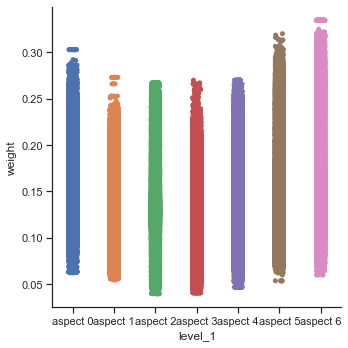

In [71]:
g = sns.catplot(x="level_1", y="weight", data=df_stack)

In [75]:
topic_weights["label"] = topic_weights.iloc[:,range(2,topic_weights.shape[1])].idxmax(axis=1)
topic_weights["weight"] = topic_weights.iloc[:,range(2,topic_weights.shape[1])].max(axis=1)

topic_weights.head()

,review_index,review,aspect 0,aspect 1,aspect 2,aspect 3,aspect 4,aspect 5,aspect 6,label,weight
0,299,great people care make difference,0.199256,0.167515,0.134292,0.157152,0.138753,0.103887,0.099146,aspect 0,0.199256
1,299,management care employee well provide continue...,0.180375,0.115645,0.217802,0.119747,0.113114,0.135779,0.117537,aspect 2,0.217802
2,1145,powerhouse epc go heavy worksharing,0.113529,0.169318,0.133917,0.163855,0.111553,0.151671,0.156157,aspect 1,0.169318
3,1145,send much work overseas possible keep core person,0.175775,0.123280,0.128013,0.103669,0.127063,0.117402,0.224798,aspect 6,0.224798
4,1145,heavy load management,0.232514,0.072758,0.191302,0.196891,0.070873,0.125174,0.110488,aspect 0,0.232514


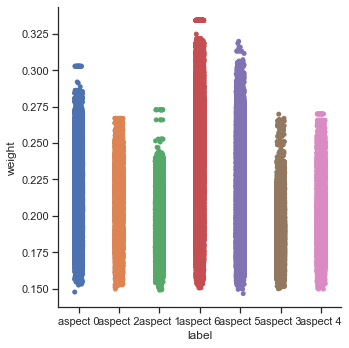

In [76]:
g = sns.catplot(x="label", y="weight", data=topic_weights)

In [78]:
idx = topic_weights.weight >= 0.20
filtered_weights = topic_weights.loc[idx, :]
print(filtered_weights.shape)
filtered_weights.head()

(89089, 11)


,review_index,review,aspect 0,aspect 1,aspect 2,aspect 3,aspect 4,aspect 5,aspect 6,label,weight
1,299,management care employee well provide continue...,0.180375,0.115645,0.217802,0.119747,0.113114,0.135779,0.117537,aspect 2,0.217802
3,1145,send much work overseas possible keep core person,0.175775,0.123280,0.128013,0.103669,0.127063,0.117402,0.224798,aspect 6,0.224798
4,1145,heavy load management,0.232514,0.072758,0.191302,0.196891,0.070873,0.125174,0.110488,aspect 0,0.232514
5,1145,project hire thousand oil boom,0.147301,0.151481,0.098867,0.103021,0.133798,0.234331,0.131201,aspect 5,0.234331
10,1375,enjoy work people work,0.225385,0.097811,0.114596,0.062885,0.128839,0.074561,0.295921,aspect 6,0.295921


In [79]:
reviews_filtered = filtered_weights.review.tolist()
labels = filtered_weights.label.tolist()

topics = set(labels)

aspects = { topic:[] for topic in topics }

for label, review in zip(labels, reviews_filtered):
    aspects[label].append(review)
    
x = 0
for aspect, corpus in aspects.items():
    print("Aspect {0} - {1} sentences".format(aspect, len(corpus)))
    x = x + len(corpus)
             
print(x)

Aspect aspect 2 - 7730 sentences
Aspect aspect 6 - 36675 sentences
Aspect aspect 3 - 3524 sentences
Aspect aspect 4 - 6423 sentences
Aspect aspect 0 - 15418 sentences
Aspect aspect 1 - 4770 sentences
Aspect aspect 5 - 14549 sentences
89089


In [84]:
from collections import Counter
from nltk import bigrams

aspects_top_vocab = { "aspect " + str(i): [] for i in range(len(topics))}

for aspect, sents in aspects.items():
    vocab = Counter()
    
    for sent in sents:
        tokens = sent.split(" ")
        bi_grams = bigrams(tokens)
        for token in bi_grams:
            vocab[" ".join(token)] += 1
        
        for token in tokens:
            vocab[token] += 1
    
    aspects_top_vocab[aspect] = [ w[0] for w in vocab.most_common(100) ]

with open("../results/ABAE/abae-k-7-filtered.json", "w") as f:
    json.dump(aspects_top_vocab, f)

In [86]:
aspects_top_vocab

{'aspect 0': ['management',
  'work',
  'good',
  'manager',
  'people',
  'job',
  'co-worker',
  'employee',
  'great',
  'friendly',
  'supportive',
  'culture',
  'environment',
  'helpful',
  'management good',
  'place',
  'part',
  'help',
  'project',
  'enjoy',
  'good management',
  'always',
  'part job',
  'colleague',
  'support',
  'also',
  'work culture',
  'lot',
  'well',
  'staff',
  'hard',
  'balance',
  'work environment',
  'really',
  'need',
  'life',
  'time',
  'good work',
  'make',
  'member',
  'everyone',
  'work place',
  'care',
  'coworker',
  'experience',
  'enjoy part',
  'excellent',
  'place work',
  'fun',
  'client',
  'professional',
  'work life',
  'upper',
  'skill',
  'level',
  'senior',
  'poor',
  'customer',
  'upper management',
  'depend',
  'life balance',
  'one',
  'like',
  'hard part',
  'leadership',
  'bad',
  'management supportive',
  'many',
  'much',
  'issue',
  'encourage',
  'provide',
  "n't",
  'high',
  'opportunity',